# Medical Expenditure 

The specific data used is the [2015 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-181) as well as the [2016 Full Year Consolidated Data File](https://meps.ahrq.gov/mepsweb/data_stats/download_data_files_detail.jsp?cboPufNumber=HC-192).

The 2015 file contains data from rounds 3,4,5 of panel 19 (2014) and rounds 1,2,3 of panel 20 (2015). The 2016 file contains data from rounds 3,4,5 of panel 20 (2015) and rounds 1,2,3 of panel 21 (2016).

For this demonstration, three datasets were constructed: one from panel 19, round 5 (used for learning models), one from panel 20, round 3 (used for deployment/testing of model - steps); the other from panel 21, round 3 (used for re-training and deployment/testing of updated model).

For each dataset, the sensitive attribute is 'RACE' constructed as follows: 'Whites' (privileged class) defined by the features RACEV2X = 1 (White) and HISPANX = 2 (non Hispanic); 'Non-Whites' that included everyone else.  

Along with race as the sensitive feature, other features used for modeling include demographics  (such as age, gender, active duty status), physical/mental health assessments, diagnosis codes (such as history of diagnosis of cancer, or diabetes), and limitations (such as cognitive or hearing or vision limitation).

The model classification task is to predict whether a person would have 'high' utilization (defined as UTILIZATION >= 10, roughly the average utilization for the considered population). High utilization respondents constituted around 17% of each dataset.

To simulate the scenario, each dataset is split into 3 parts: a train, a validation, and a test/deployment part.


## [3.](#Table-of-Contents) Training models on original 2015 Panel 19 data

First, load all necessary packages

In [1]:
import sys
sys.path.insert(0, '../')

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown, display

# Datasets
from aif360.datasets import MEPSDataset19
from aif360.datasets import MEPSDataset20
from aif360.datasets import MEPSDataset21

# Fairness metrics
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric

# Explainers
from aif360.explainers import MetricTextExplainer

# Scalers
from sklearn.preprocessing import StandardScaler

# Classifiers
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Bias mitigation techniques
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.inprocessing import PrejudiceRemover

# LIME
from aif360.datasets.lime_encoder import LimeEncoder
import lime
from lime.lime_tabular import LimeTabularExplainer

np.random.seed(1)

2024-04-08 12:21:47.322976: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### 3.1. Load data & create splits for learning/validating/testing model

In [2]:
%matplotlib inline
# data manipulation libraries
import pandas as pd
import numpy as np

from time import time

# Graphs libraries
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff
from plotly import tools

# Libraries to study
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
from aif360.algorithms.preprocessing import LFR, Reweighing
from aif360.algorithms.inprocessing import AdversarialDebiasing, PrejudiceRemover
from aif360.algorithms.postprocessing import CalibratedEqOddsPostprocessing, EqOddsPostprocessing, RejectOptionClassification

# ML libraries
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

# Design libraries
from IPython.display import Markdown, display
import warnings
warnings.filterwarnings("ignore")

Get the dataset and split into train (50%), validate (30%), and test (20%)

In [3]:
(dataset_orig_panel19_train,
 dataset_orig_panel19_val,
 dataset_orig_panel19_test) = MEPSDataset19().split([0.5, 0.8], shuffle=True)

sens_ind = 0
sens_attr = dataset_orig_panel19_train.protected_attribute_names[sens_ind]

unprivileged_groups = [{sens_attr: v} for v in
                       dataset_orig_panel19_train.unprivileged_protected_attributes[sens_ind]]
privileged_groups = [{sens_attr: v} for v in
                     dataset_orig_panel19_train.privileged_protected_attributes[sens_ind]]

In [4]:
dataset_orig_panel19_test

               instance weights features                                    \
                                         protected attribute                 
                                     AGE                RACE  PCS42  MCS42   
instance names                                                               
6734                8770.425719     68.0                 0.0  37.82  59.53   
12972               2909.245554     70.0                 0.0  43.05  59.07   
642                 2142.962735     46.0                 0.0  53.73  48.68   
4383               13704.021921     16.0                 1.0  -1.00  -1.00   
6011                7310.287974     85.0                 1.0  32.62  43.69   
...                         ...      ...                 ...    ...    ...   
952                 9696.134287      9.0                 1.0  -1.00  -1.00   
5442               21257.994423     46.0                 1.0  55.93  52.08   
12733               5211.737528      0.0                 0.0  -1

This function will be used throughout the notebook to print out some labels, names, etc.

In [5]:
def describe(train=None, val=None, test=None):
    if train is not None:
        display(Markdown("#### Training Dataset shape"))
        print(train.features.shape)
    if val is not None:
        display(Markdown("#### Validation Dataset shape"))
        print(val.features.shape)
    display(Markdown("#### Test Dataset shape"))
    print(test.features.shape)
    display(Markdown("#### Favorable and unfavorable labels"))
    print(test.favorable_label, test.unfavorable_label)
    display(Markdown("#### Protected attribute names"))
    print(test.protected_attribute_names)
    display(Markdown("#### Privileged and unprivileged protected attribute values"))
    print(test.privileged_protected_attributes, 
          test.unprivileged_protected_attributes)
    display(Markdown("#### Dataset feature names"))
    print(test.feature_names)

Show 2015 dataset details

In [6]:
describe(dataset_orig_panel19_train, dataset_orig_panel19_val, dataset_orig_panel19_test)

#### Training Dataset shape

(7915, 138)


#### Validation Dataset shape

(4749, 138)


#### Test Dataset shape

(3166, 138)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['RACE']


#### Privileged and unprivileged protected attribute values

[array([1.])] [array([0.])]


#### Dataset feature names

['AGE', 'RACE', 'PCS42', 'MCS42', 'K6SUM42', 'REGION=1', 'REGION=2', 'REGION=3', 'REGION=4', 'SEX=1', 'SEX=2', 'MARRY=1', 'MARRY=2', 'MARRY=3', 'MARRY=4', 'MARRY=5', 'MARRY=6', 'MARRY=7', 'MARRY=8', 'MARRY=9', 'MARRY=10', 'FTSTU=-1', 'FTSTU=1', 'FTSTU=2', 'FTSTU=3', 'ACTDTY=1', 'ACTDTY=2', 'ACTDTY=3', 'ACTDTY=4', 'HONRDC=1', 'HONRDC=2', 'HONRDC=3', 'HONRDC=4', 'RTHLTH=-1', 'RTHLTH=1', 'RTHLTH=2', 'RTHLTH=3', 'RTHLTH=4', 'RTHLTH=5', 'MNHLTH=-1', 'MNHLTH=1', 'MNHLTH=2', 'MNHLTH=3', 'MNHLTH=4', 'MNHLTH=5', 'HIBPDX=-1', 'HIBPDX=1', 'HIBPDX=2', 'CHDDX=-1', 'CHDDX=1', 'CHDDX=2', 'ANGIDX=-1', 'ANGIDX=1', 'ANGIDX=2', 'MIDX=-1', 'MIDX=1', 'MIDX=2', 'OHRTDX=-1', 'OHRTDX=1', 'OHRTDX=2', 'STRKDX=-1', 'STRKDX=1', 'STRKDX=2', 'EMPHDX=-1', 'EMPHDX=1', 'EMPHDX=2', 'CHBRON=-1', 'CHBRON=1', 'CHBRON=2', 'CHOLDX=-1', 'CHOLDX=1', 'CHOLDX=2', 'CANCERDX=-1', 'CANCERDX=1', 'CANCERDX=2', 'DIABDX=-1', 'DIABDX=1', 'DIABDX=2', 'JTPAIN=-1', 'JTPAIN=1', 'JTPAIN=2', 'ARTHDX=-1', 'ARTHDX=1', 'ARTHDX=2', 'ARTHTYPE=-1'

Metrics for original data

In [7]:
metric_orig_panel19_train = BinaryLabelDatasetMetric(
        dataset_orig_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_orig_panel19_train = MetricTextExplainer(metric_orig_panel19_train)

print(explainer_orig_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 0.482305229962759


Both the models have some good metrics (not excellent), so I will use these models for origin models.

## <a id='4'>4. Bias and Fairness</a>

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://github.com/IBM/AIF360) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### <a id='4.1'>4.1 Metrics</a>

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### <a id='4.1.1'>4.1.1 Statistical Parity Difference</a>

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### <a id='4.1.2'>4.1.2 Equal Opportunity Difference</a>

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### <a id='4.1.3'>4.1.3 Average Absolute Odds Difference</a>

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### <a id='4.1.4'>4.1.4 Disparate Impact</a>

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### <a id='4.1.5'>4.1.5 Theil Index</a>

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.



### 3.2. Learning a Logistic Regression (LR) classifier on original data

#### 3.2.1. Training LR model on original data

In [8]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}

lr_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.2.2. Validating LR model on original data

This function will be used throughout the tutorial to find best threshold using a validation set

In [9]:
from collections import defaultdict

def test(dataset, model, thresh_arr):
    try:
        # sklearn classifier
        y_val_pred_prob = model.predict_proba(dataset.features)
        pos_ind = np.where(model.classes_ == dataset.favorable_label)[0][0]
    except AttributeError:
        # aif360 inprocessing algorithm
        y_val_pred_prob = model.predict(dataset).scores
        pos_ind = 0
    
    metric_arrs = defaultdict(list)
    for thresh in thresh_arr:
        y_val_pred = (y_val_pred_prob[:, pos_ind] > thresh).astype(np.float64)

        dataset_pred = dataset.copy()
        dataset_pred.labels = y_val_pred
        metric = ClassificationMetric(
                dataset, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

        metric_arrs['bal_acc'].append((metric.true_positive_rate()
                                     + metric.true_negative_rate()) / 2)
        metric_arrs['avg_odds_diff'].append(metric.average_odds_difference())
        metric_arrs['disp_imp'].append(metric.disparate_impact())
        metric_arrs['stat_par_diff'].append(metric.statistical_parity_difference())
        metric_arrs['eq_opp_diff'].append(metric.equal_opportunity_difference())
        metric_arrs['theil_ind'].append(metric.theil_index())
    
    return metric_arrs

In [10]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_orig_panel19,
                   thresh_arr=thresh_arr)
lr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

Make a function to print out accuracy and fairness metrics. This will be used throughout the tutorial.

In [11]:
def describe_metrics(metrics, thresh_arr):
    best_ind = np.argmax(metrics['bal_acc'])
    print("Threshold corresponding to Best balanced accuracy: {:6.4f}".format(thresh_arr[best_ind]))
    print("Best balanced accuracy: {:6.4f}".format(metrics['bal_acc'][best_ind]))
#     disp_imp_at_best_ind = np.abs(1 - np.array(metrics['disp_imp']))[best_ind]
    disp_imp_at_best_ind = 1 - min(metrics['disp_imp'][best_ind], 1/metrics['disp_imp'][best_ind])
    print("Corresponding 1-min(DI, 1/DI) value: {:6.4f}".format(disp_imp_at_best_ind))
    print("Corresponding average odds difference value: {:6.4f}".format(metrics['avg_odds_diff'][best_ind]))
    print("Corresponding statistical parity difference value: {:6.4f}".format(metrics['stat_par_diff'][best_ind]))
    print("Corresponding equal opportunity difference value: {:6.4f}".format(metrics['eq_opp_diff'][best_ind]))
    print("Corresponding Theil index value: {:6.4f}".format(metrics['theil_ind'][best_ind]))

In [12]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7627
Corresponding 1-min(DI, 1/DI) value: 0.6066
Corresponding average odds difference value: -0.1831
Corresponding statistical parity difference value: -0.2643
Corresponding equal opportunity difference value: -0.1608
Corresponding Theil index value: 0.0936


#### 3.2.3. Testing LR model on original data

In [13]:
lr_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=lr_orig_panel19,
                       thresh_arr=[thresh_arr[lr_orig_best_ind]])

In [14]:
describe_metrics(lr_orig_metrics, [thresh_arr[lr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1900
Best balanced accuracy: 0.7759
Corresponding 1-min(DI, 1/DI) value: 0.5738
Corresponding average odds difference value: -0.2057
Corresponding statistical parity difference value: -0.2612
Corresponding equal opportunity difference value: -0.2228
Corresponding Theil index value: 0.0921


For all the fairness metrics displayed above, the value should be close to '0' for fairness.

1-min(DI, 1/DI) < 0.2 is typically desired for classifier predictions to be fair.

However, for a logistic regression classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

Similarly, $\text{average odds difference} = \frac{(FPR_{unpriv}-FPR_{priv})+(TPR_{unpriv}-TPR_{priv})}{2}$ must be close to zero for the classifier to be fair.

Again, the results for this classifier-data combination are still high. This still implies unfairness.

### 3.3. Learning a Random Forest (RF) classifier on original data

#### 3.3.1. Training RF model on original data

In [15]:
dataset = dataset_orig_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_orig_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 3.3.2. Validating RF model on original data

In [16]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_orig_panel19,
                   thresh_arr=thresh_arr)
rf_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [17]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7727
Corresponding 1-min(DI, 1/DI) value: 0.4891
Corresponding average odds difference value: -0.1174
Corresponding statistical parity difference value: -0.1952
Corresponding equal opportunity difference value: -0.1076
Corresponding Theil index value: 0.0893


#### 3.3.3. Testing RF model on original data

In [18]:
rf_orig_metrics = test(dataset=dataset_orig_panel19_test,
                       model=rf_orig_panel19,
                       thresh_arr=[thresh_arr[rf_orig_best_ind]])

In [19]:
describe_metrics(rf_orig_metrics, [thresh_arr[rf_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7640
Corresponding 1-min(DI, 1/DI) value: 0.5040
Corresponding average odds difference value: -0.1346
Corresponding statistical parity difference value: -0.2121
Corresponding equal opportunity difference value: -0.1141
Corresponding Theil index value: 0.0944


As in the case of the logistic regression classifier learned on the original data, the fairness metrics for the random forest classifier have values that are quite far from 0.

For example, 1 - min(DI, 1/DI) has a value of over 0.5 as opposed to the desired value of < 0.2.

This indicates that the random forest classifier learned on the original data is also unfair.

## [4.](#Table-of-Contents) Bias mitigation using pre-processing technique - Reweighing

### 4.1. Transform data

In [20]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf_panel19_train = RW.fit_transform(dataset_orig_panel19_train)

Metrics for transformed data

In [21]:
metric_transf_panel19_train = BinaryLabelDatasetMetric(
        dataset_transf_panel19_train,
        unprivileged_groups=unprivileged_groups,
        privileged_groups=privileged_groups)
explainer_transf_panel19_train = MetricTextExplainer(metric_transf_panel19_train)

print(explainer_transf_panel19_train.disparate_impact())

Disparate impact (probability of favorable outcome for unprivileged instances / probability of favorable outcome for privileged instances): 1.0


### 4.2. Learning a Logistic Regression (LR) classifier on data transformed by reweighing

#### 4.2.1. Training LR model after reweighing

In [22]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      LogisticRegression(solver='liblinear', random_state=1))
fit_params = {'logisticregression__sample_weight': dataset.instance_weights}
lr_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.2.2. Validating  LR model after reweighing

In [23]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=lr_transf_panel19,
                   thresh_arr=thresh_arr)
lr_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [24]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7581
Corresponding 1-min(DI, 1/DI) value: 0.2939
Corresponding average odds difference value: -0.0084
Corresponding statistical parity difference value: -0.0992
Corresponding equal opportunity difference value: 0.0242
Corresponding Theil index value: 0.0938


#### 4.2.3. Testing  LR model after reweighing

In [25]:
lr_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=lr_transf_panel19,
                         thresh_arr=[thresh_arr[lr_transf_best_ind]])

In [26]:
describe_metrics(lr_transf_metrics, [thresh_arr[lr_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2200
Best balanced accuracy: 0.7539
Corresponding 1-min(DI, 1/DI) value: 0.2482
Corresponding average odds difference value: -0.0151
Corresponding statistical parity difference value: -0.0872
Corresponding equal opportunity difference value: -0.0035
Corresponding Theil index value: 0.0966


The fairness metrics for the logistic regression model learned after reweighing are well improved, and thus the model is much more fair relative to the logistic regression model learned from the original data.

### 4.3. Learning a Random Forest (RF) classifier on data transformed by reweighing

#### 4.3.1. Training  RF model after reweighing

In [27]:
dataset = dataset_transf_panel19_train
model = make_pipeline(StandardScaler(),
                      RandomForestClassifier(n_estimators=500, min_samples_leaf=25))
fit_params = {'randomforestclassifier__sample_weight': dataset.instance_weights}
rf_transf_panel19 = model.fit(dataset.features, dataset.labels.ravel(), **fit_params)

#### 4.3.2. Validating  RF model after reweighing

In [28]:
thresh_arr = np.linspace(0.01, 0.5, 50)
val_metrics = test(dataset=dataset_orig_panel19_val,
                   model=rf_transf_panel19,
                   thresh_arr=thresh_arr)
rf_transf_best_ind = np.argmax(val_metrics['bal_acc'])

In [29]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7721
Corresponding 1-min(DI, 1/DI) value: 0.4142
Corresponding average odds difference value: -0.0827
Corresponding statistical parity difference value: -0.1623
Corresponding equal opportunity difference value: -0.0713
Corresponding Theil index value: 0.0882


#### 4.3.3. Testing  RF model after reweighing

In [30]:
rf_transf_metrics = test(dataset=dataset_orig_panel19_test,
                         model=rf_transf_panel19,
                         thresh_arr=[thresh_arr[rf_transf_best_ind]])

In [31]:
describe_metrics(rf_transf_metrics, [thresh_arr[rf_transf_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.2300
Best balanced accuracy: 0.7644
Corresponding 1-min(DI, 1/DI) value: 0.4336
Corresponding average odds difference value: -0.1014
Corresponding statistical parity difference value: -0.1776
Corresponding equal opportunity difference value: -0.0842
Corresponding Theil index value: 0.0938


Once again, the model learned from the transformed data is fairer than that learned from the original data. However, the random forest model learned from the transformed data is still relatively unfair as compared to the logistic regression model learned from the transformed data.

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### <a id='4.2'>4.2 How to fix it ?</a>

AIF360 use 3 types of algorithms :
* Pre-processing algorithms : they are used before training the model
* In-processing algorithms : they are fair classifiers so it's during the training
* Post-processing algorithms : they are used after training the model

![Fairness pipeline](http://image.noelshack.com/fichiers/2018/50/1/1544437769-fairness-pipeline.png)

This is the **fairness pipeline**. An example instantiation of this generic pipeline consists of loading data into a dataset object, transforming
it into a fairer dataset using a fair pre-processing algorithm, learning a classifier from this transformed dataset, and obtaining
predictions from this classifier. Metrics can be calculated on the original, transformed, and predicted datasets as well as between the
transformed and predicted datasets. Many other instantiations are also possible (more information on [the aif360 paper](https://arxiv.org/pdf/1810.01943.pdf)).

#### <a id='4.2.1'>4.2.1 Pre-processing algorithms </a>

There are 4 pre-processing algorithms but for 3 of them **there is a problem** : it will work only if the dataset have one protected attribute but here we have 2 : *Sex* and *Race*. But let's have a quick intro for all of them and at the end I will use the one that work for my case.

Because this notebook is an exploration of fairness into models I will only use 1 protected attribute : Victim Race, it will allow me to use almost all the algorithms (but for your information the *Reweighing* algo can works with all protected so that's why I will create a function that gives me the protected and unprotected attributes.

You can find all the code information on [the documentation](https://aif360.readthedocs.io/en/latest/modules/preprocessing.html#)



In [32]:
def get_attributes(data, selected_attr=None):
    unprivileged_groups = []
    privileged_groups = []
    if selected_attr == None:
        selected_attr = data.protected_attribute_names
    
    for attr in selected_attr:
            idx = data.protected_attribute_names.index(attr)
            privileged_groups.append({attr:data.privileged_protected_attributes[idx]}) 
            unprivileged_groups.append({attr:data.unprivileged_protected_attributes[idx]}) 

    return privileged_groups, unprivileged_groups

In [33]:
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [34]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [35]:
def get_fair_metrics_and_plot(data, model, plot=True, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

*****
##### <a id='4.2.1.1'>4.2.1.1 Disparate impact remover</a>
Source : [Feldman et al., 2015](https://dl.acm.org/citation.cfm?doid=2783258.2783311)

Disparate impact remover is a preprocessing technique that edits feature values increase group fairness while preserving rank-ordering within groups.
If you want to see how it works you can take a look on [an example Notebook from the GitHub of AIF360](https://github.com/IBM/AIF360/blob/master/examples/demo_disparate_impact_remover.ipynb).




In [36]:
data_orig_train, data_orig_test = dataset_orig_panel19_train, dataset_orig_panel19_test

In [37]:
from aif360.algorithms.preprocessing import DisparateImpactRemover
DIR = DisparateImpactRemover()
data_transf_train = DIR.fit_transform(dataset_orig_panel19_train)

rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = DIR.fit_transform(dataset_orig_panel19_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(dataset_orig_panel19_test.features)
preds = rf_transf.predict(dataset_orig_panel19_test.features)



algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'DisparateImpact')

y_val_pred = rf_transf.predict(dataset_orig_panel19_val.features)
dataset_pred = dataset_orig_panel19_val.copy()
dataset_pred.labels = y_val_pred

metric = ClassificationMetric(
                dataset_orig_panel19_val, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

acc1 = np.mean( rf_transf.predict(dataset_orig_panel19_val.features) == dataset_orig_panel19_val.labels.ravel())
acc = (metric.true_positive_rate()+ metric.true_negative_rate()) / 2

print('accuracy score :: ', acc)


accuracy score ::  0.6614021923764136


*****
##### <a id='4.2.1.2'>4.2.1.2 Learning fair representations</a>
Source : [Zemel et al., 2013](http://proceedings.mlr.press/v28/zemel13.html)

Learning fair representations is a pre-processing technique that finds a latent representation which encodes the data.


In [38]:
np.count_nonzero(data_transf_test.labels)


553

In [39]:
privileged_groups, unprivileged_groups = get_attributes(dataset_orig_panel19_train, selected_attr=['RACE'])


LFR_model = LFR(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups, k=1, verbose=0)
# LFR.fit(data_orig_train)
data_transf_train = LFR_model.fit_transform(dataset_orig_panel19_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = LFR_model.transform(dataset_orig_panel19_test)
fair = get_fair_metrics_and_plot(data_transf_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(dataset_orig_panel19_test.features)
preds = rf_transf.predict(dataset_orig_panel19_test.features)

algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'LFR')

data_transf_test

y_val_pred = rf_transf.predict(dataset_orig_panel19_val.features)
dataset_pred = dataset_orig_panel19_val.copy()
dataset_pred.labels = y_val_pred

metric = ClassificationMetric(
                dataset_orig_panel19_val, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

acc1 = np.mean( rf_transf.predict(dataset_orig_panel19_val.features) == dataset_orig_panel19_val.labels.ravel())
acc = (metric.true_positive_rate()+ metric.true_negative_rate()) / 2

print('accuracy score :: ', acc)



accuracy score ::  0.5


*****
##### <a id='4.2.1.3'>4.2.1.3 Optimized preprocessing</a>
Source : [Calmon et al., 2017](http://papers.nips.cc/paper/6988-optimized-pre-processing-for-discrimination-prevention)

Optimized preprocessing is a preprocessing technique that learns a probabilistic transformation that edits the features and labels in the data with group fairness, individual distortion, and data fidelity constraints and objectives.
There is also [a demo notebook on the aif360 GitHub](https://github.com/IBM/AIF360/blob/master/examples/demo_optim_data_preproc.ipynb).

*To be honest I tried to work with this one but it's more complicated : it uses options that you have to configure yourself and I don't really find how to choose it. Also it use an Optimizer and I didn't find how to build this class. (I didn't read the paper about this algorithm)*
*****
##### <a id='4.2.1.4'>4.2.1.4 Reweighing</a>
Source : [Kamiran and Calders, 2012](https://link.springer.com/article/10.1007%2Fs10115-011-0463-8)

Reweighing is a preprocessing technique that Weights the examples in each (group, label) combination differently to ensure fairness before classification.

In [40]:
privileged_groups, unprivileged_groups = get_attributes(data_orig_train, selected_attr=['RACE'])
t0 = time()

RW = Reweighing(unprivileged_groups=unprivileged_groups, privileged_groups=privileged_groups)
# RW.fit(data_orig_train)
data_transf_train = RW.fit_transform(data_orig_train)

# Train and save the model
rf_transf = RandomForestClassifier().fit(data_transf_train.features, 
                     data_transf_train.labels.ravel(), 
                     sample_weight=data_transf_train.instance_weights)

data_transf_test = RW.transform(data_orig_test)
fair = get_fair_metrics_and_plot(data_orig_test, rf_transf, plot=False)
probs = rf_transf.predict_proba(data_orig_test.features)
preds = rf_transf.predict(data_orig_test.features)


algo_metrics = add_to_df_algo_metrics(algo_metrics, rf_transf, fair, preds, probs, 'Reweighing')

y_val_pred = rf_transf.predict(dataset_orig_panel19_val.features)
dataset_pred = dataset_orig_panel19_val.copy()
dataset_pred.labels = y_val_pred

metric = ClassificationMetric(
                dataset_orig_panel19_val, dataset_pred,
                unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

acc1 = np.mean( rf_transf.predict(dataset_orig_panel19_val.features) == dataset_orig_panel19_val.labels.ravel())
acc = (metric.true_positive_rate()+ metric.true_negative_rate()) / 2

print('accuracy score :: ', acc)


accuracy score ::  0.6660902444860455


In [41]:
for i in range(len(algo_metrics)):
    print("model name :: ", algo_metrics.index[i])
    display("fairness metrics :: ", algo_metrics["fair_metrics"][i])

model name ::  DisparateImpact


'fairness metrics :: '

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.000000,0.000000,1.000000,0.000000
RACE,-0.096713,-0.128292,0.086505,0.379777,0.135121


model name ::  LFR


'fairness metrics :: '

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.0,0.0,0.0,1.0,0.0
RACE,0.0,NaN,NaN,NaN,0.0


model name ::  Reweighing


'fairness metrics :: '

,statistical_parity_difference,equal_opportunity_difference,average_abs_odds_difference,disparate_impact,theil_index
objective,0.000000,0.00000,0.000000,1.000000,0.000000
RACE,-0.094389,-0.10969,0.077885,0.388609,0.132464


## [5.](#Table-of-Contents) Bias mitigation using in-processing technique - Prejudice Remover (PR)

### 5.1. Learning a Prejudice Remover (PR) model on original data

#### 5.1.1. Training a PR model

In [42]:
model = PrejudiceRemover(sensitive_attr=sens_attr, eta=25.0)
pr_orig_scaler = StandardScaler()

dataset = dataset_orig_panel19_train.copy()
dataset.features = pr_orig_scaler.fit_transform(dataset.features)

pr_orig_panel19 = model.fit(dataset)

#### 5.1.2. Validating PR model

In [43]:
thresh_arr = np.linspace(0.01, 0.50, 50)

dataset = dataset_orig_panel19_val.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

val_metrics = test(dataset=dataset,
                   model=pr_orig_panel19,
                   thresh_arr=thresh_arr)
pr_orig_best_ind = np.argmax(val_metrics['bal_acc'])

In [44]:
describe_metrics(val_metrics, thresh_arr)

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6836
Corresponding 1-min(DI, 1/DI) value: 0.2262
Corresponding average odds difference value: 0.0256
Corresponding statistical parity difference value: -0.0828
Corresponding equal opportunity difference value: 0.1172
Corresponding Theil index value: 0.1119


#### 5.1.3. Testing PR model

In [45]:
dataset = dataset_orig_panel19_test.copy()
dataset.features = pr_orig_scaler.transform(dataset.features)

pr_orig_metrics = test(dataset=dataset,
                       model=pr_orig_panel19,
                       thresh_arr=[thresh_arr[pr_orig_best_ind]])

In [46]:
describe_metrics(pr_orig_metrics, [thresh_arr[pr_orig_best_ind]])

Threshold corresponding to Best balanced accuracy: 0.1200
Best balanced accuracy: 0.6880
Corresponding 1-min(DI, 1/DI) value: 0.1588
Corresponding average odds difference value: 0.0523
Corresponding statistical parity difference value: -0.0566
Corresponding equal opportunity difference value: 0.1479
Corresponding Theil index value: 0.1108


As in the case of reweighing, prejudice remover results in a fair model. However, it has come at the expense of relatively lower balanced accuracy.

## [6.](#Table-of-Contents) Summary of Model Learning Results

In [47]:
import pandas as pd
pd.set_option('display.multi_sparse', False)
results = [lr_orig_metrics, rf_orig_metrics, lr_transf_metrics,
           rf_transf_metrics, pr_orig_metrics]
debias = pd.Series(['']*2 + ['Reweighing']*2
                 + ['Prejudice Remover'],
                   name='Bias Mitigator')
clf = pd.Series(['Logistic Regression', 'Random Forest']*2 + [''],
                name='Classifier')
pd.concat([pd.DataFrame(metrics) for metrics in results], axis=0).set_index([debias, clf])

,,bal_acc,avg_odds_diff,disp_imp,stat_par_diff,eq_opp_diff,theil_ind
Bias Mitigator,Classifier,,,,,,
,Logistic Regression,0.775935,-0.205706,0.426176,-0.261207,-0.222779,0.092122
,Random Forest,0.764042,-0.134638,0.495973,-0.212121,-0.114076,0.094373
Reweighing,Logistic Regression,0.753893,-0.015104,0.751755,-0.087196,-0.003518,0.096575
Reweighing,Random Forest,0.764359,-0.101374,0.566427,-0.177582,-0.084247,0.093787
Prejudice Remover,,0.688028,0.052286,0.841229,-0.056631,0.147869,0.110774


Of all the models, the logistic regression model gives the best balance in terms of balanced accuracy and fairness. While the model learnt by prejudice remover is slightly fairer, it has much lower accuracy. All other models are quite unfair compared to the logistic model. Hence, we take the logistic regression model learnt from data transformed by re-weighing and 'deploy' it.

## [7.](#Table-of-Contents) Paper

In [48]:
import math
from copy import copy
import numpy as np

class  ObliviousData:
    def build_O_discrete(self,K,S):
        n = math.floor(((np.shape(K))[1])/2) # n = half the samples
        self.n = n
        self.K=K[:2*n,:2*n] #remove one data point if n is odd
        
        #Bin S
        S_binned = S #assuming that S is discrete and starts at 0
        self.S_train = S_binned[0:n]
        self.S_cond = S_binned[n:2*n]
        
        self.S_max = int(max(S_binned)+1) 
   
        #precompute

        Ephi = np.mean(K[n:,n:])
        
        mean_iI = np.zeros((n,self.S_max))
        mean_i = np.zeros((n,1))
        for i in range(n):
            mean_i[i] = np.mean(K[i,n:])
            for u in range(self.S_max): 
                I = n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
                mean_iI[i,u] = np.mean(K[i,I])

        mean_I = np.zeros((self.S_max,1))
        mean_IJ = np.zeros((self.S_max,self.S_max))
        for u in range(self.S_max):
            I = n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
            mean_I[u] = np.mean(K[I,n:])
            for v in range(self.S_max):
                J = n + np.where(self.S_cond==v)[0] # all I in cond which correspond to sensitive value v
                mean_IJ[u,v] = np.mean((K[I,:])[:,J]) 


        #final loop
        O = copy(K[:n,:n]) #Kernel matrix for the first n elements
        for i in range(n):
            for j in range(i,n):
                u = int(self.S_train[i])
                v = int(self.S_train[j])
    
                O[i,j] = O[i,j] - mean_iI[i,v]  - mean_iI[j,u]  + mean_IJ[u,v] + mean_i[j] + mean_i[i] - mean_I[u] - mean_I[v]  + Ephi
                O[j,i] = O[i,j]
                
        self.O = O
        self.mean_i = mean_i
        self.mean_iI = mean_iI
        self.mean_I = mean_I
        self.mean_IJ = mean_IJ
        self.Ephi = Ephi
                
        return O
    
    
    def build_Ot_discrete(self,Kt,St): #Kt has size testsample x 2n 
        Ot = copy(Kt[:,:self.n])
        m = (np.shape(Kt))[0]
    
        mean_test_iI = np.zeros((m,self.S_max))
        mean_test_i = np.zeros((m,1))
        for i in range(m):
            mean_test_i[i] = np.mean(Kt[i,self.n:])
            for u in range(self.S_max):
                I = self.n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
                mean_test_iI[i,u] = np.mean(Kt[i,I])

        for i in range(m):
            for j in range(self.n): #not symmetric anymore so we need to go through all
                u = int(St[i])
                v = int(self.S_train[j]) 
                Ot[i,j] = Ot[i,j] - mean_test_iI[i,v]- self.mean_iI[j,u]  + self.mean_IJ[u,v]  +  self.mean_i[j] + mean_test_i[i]  - self.mean_I[u] - self.mean_I[v]  + self.Ephi # i corresponds to test, j to train; 
        self.Ot = Ot
        return self.Ot 
    
    
    def predict_g(self,Kt, St): #for M-Oblivious 
        m = (np.shape(Kt))[0]#kt has size testsample x 2n 
        mean_test_iI = np.zeros((self.n,self.S_max))
        mean_test_i = np.zeros((self.n,1))
        for i in range(self.n):
            mean_test_i[i] = np.mean(self.K[i,self.n:])
            for u in range(self.S_max):
                I = self.n + np.where(self.S_cond==u)[0] # all i in cond which correspond to sensitive value u
                mean_test_iI[i,u] = np.mean(self.K[i,I])
        
        M_XS = np.matlib.repmat(mean_test_i, 1, self.S_max)-mean_test_iI
        gOt=np.zeros((m,self.n))
        for i in range(m):
            gOt[i,:]=M_XS[:,St[i][0][0]]
        
        gOt= gOt+Kt[:,:self.n]

        return gOt 
    
    

    def build_K_rbf(self,X1,X2,sigma=1):
        # X1 has n rows = number of samples; X2 has m rows = number of samples 
        n = (np.shape(X1))[0]
        m = (np.shape(X2))[0]
        K_1 = np.zeros((n,m))
    
        for i in range(n):
            for j in range(m):
                K_1[i,j] = np.exp((-1)*(np.dot(X1[i]-X2[j],X1[i]-X2[j]))/sigma)
                
        return K_1


    def build_K_lin(self,X1,X2):
        # X1 has n rows = number of samples; X2 has m rows = number of samples 
        n = (np.shape(X1))[0]
        m = (np.shape(X2))[0]
        K = np.zeros((n,m))
    
        for i in range(n):
            for j in range(m):
                K[i,j] = np.dot(X1[i],X2[j])
        

        return K

    
    def Omatrix(self):
        return self.O
    
    def Otmatrix(self):
        return self.Ot

In [49]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import numpy.matlib
from sklearn import svm
from collections import namedtuple

def generate_truncnorm_samples(n_samples,lower,upper,mu,sigma):
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    values = X.rvs(n_samples)
    return values

def generate_toy_data(n_samples):
    sigma =0.5
    unique_sensitive_feature_values=[0,1]
    max_non_sensitive_feature_value=4.0
    min_non_sensitive_feature_value=1.0
    mu = 0.5*(max_non_sensitive_feature_value+min_non_sensitive_feature_value)
    sensitive_features = [unique_sensitive_feature_values[0]] * n_samples + [unique_sensitive_feature_values[1]] * n_samples 
    sensitive_features = np.array(sensitive_features)
    sensitive_features.shape = (len(sensitive_features), 1)
    
    Lower = generate_truncnorm_samples(n_samples,min_non_sensitive_feature_value,max_non_sensitive_feature_value,mu,sigma)
    Upper = generate_truncnorm_samples(n_samples,min_non_sensitive_feature_value,max_non_sensitive_feature_value,mu,sigma)
    non_sensitive_features0=[Lower]+[Upper]
    non_sensitive_features0 = np.array(np.hstack(non_sensitive_features0))
    non_sensitive_features0.shape=(len(non_sensitive_features0),1)
    
    
    non_sensitive_features=[Lower-stats.bernoulli(0.9).rvs(n_samples)*1]+[Upper+stats.bernoulli(0.9).rvs(n_samples)*1]
    non_sensitive_features = np.array(np.hstack(non_sensitive_features))
    non_sensitive_features.shape=(len(non_sensitive_features),1)
    
    X = np.hstack([non_sensitive_features, sensitive_features])
    
    threshold=mu
    Y_Bernoulli_params=np.array(non_sensitive_features0/max_non_sensitive_feature_value).flatten()
    Y=np.array([stats.bernoulli(Y_Bernoulli_params[i]).rvs(1) for i in range(len(Y_Bernoulli_params))]).flatten()
    True_Y=Y*(np.array((non_sensitive_features0>=threshold)*1).flatten())
    Y=Y*(np.array((non_sensitive_features+sensitive_features>=threshold)*1).flatten())
    sensitive_feature_id=np.shape(X)[1]-1

    return X, Y, sensitive_feature_id, True_Y





def estimate_beta_dependence(predicted_labels, sensitive_features, labels):
    estimated_beta=0
    n = np.size(predicted_labels)
    unique_label_freqs =[]
    for i in range(len(labels)):
        unique_label_freqs.append(np.mean(predicted_labels==labels[i]))

    unique_S_features=list(set(sensitive_features))
    unique_S_freqs =[]
    for i in range(len(unique_S_features)):
        unique_S_freqs.append(np.mean(sensitive_features==unique_S_features[i]))

    pred_feature_pairs = np.vstack((predicted_labels, sensitive_features)).T
     
    joint_freqs=[]       
    for i in range(len(labels)):
        for j in range(len(unique_S_features)):
            pattern=(labels[i],unique_S_features[j])
            joint_freq=np.size(np.where(np.sum(np.abs(pred_feature_pairs-np.matlib.repmat(pattern, n, 1)),axis=1)==0))/n
            joint_freqs.append(joint_freq)
            marginal_label_freq=unique_label_freqs[i]
            marginal_S_freq=unique_S_freqs[j]
            estimated_beta=estimated_beta+np.abs(marginal_label_freq * marginal_S_freq-joint_freq)
    return estimated_beta

In [50]:
data_orig_train

               instance weights features            features features  \
                                         protected attribute            
                                     AGE                RACE    PCS42   
instance names                                                          
6274                9584.405538     56.0                 0.0    24.59   
4403               13501.448564     19.0                 1.0    -1.00   
8660                   0.000000     73.0                 1.0    -1.00   
1220               45482.792820     73.0                 1.0    23.64   
12020               4639.875613      2.0                 0.0    -1.00   
...                         ...      ...                 ...      ...   
13556               8527.049685      7.0                 1.0    -1.00   
16232               6809.283500     18.0                 0.0    52.40   
279                 3750.437997     19.0                 0.0    56.41   
4710                6853.044637     16.0           

In [51]:
data_orig_train.features = data_orig_train.features[:-1]


In [52]:
X_train,y_train = data_orig_train.features[:3957], data_orig_train.labels[:3957].ravel()
X_cond,y_cond = data_orig_train.features[3957:], data_orig_train.labels[3957:].ravel()
X_test,y_test = dataset_orig_panel19_val.features, dataset_orig_panel19_val.labels.ravel()



X = data_orig_train.features
y = data_orig_train.labels.ravel()
S_train = data_orig_train.protected_attributes[:3957].ravel()
S_train_cond = data_orig_train.protected_attributes[3957:].ravel()
S = data_orig_train.protected_attributes.ravel()
S_test = dataset_orig_panel19_val.protected_attributes.ravel()


In [53]:
unique_labels=list(set(list(y_test)))
unique_labels

[0.0, 1.0]

In [54]:
#Plot data
plt.hist(S)


(array([5061.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        2854.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

In [55]:
len(y_train)

3957

In [56]:
C_list = [2**v for v in [0,1,2,3,4,5,6,7,8,9,10]]    
#Oblivious SVM
print('OBLIVIOUS SVM')
obl = ObliviousData()
K = obl.build_K_lin(np.array(X),np.array(X))
O = obl.build_O_discrete(K,S)
Kt = obl.build_K_lin(np.array(X_test),np.array(X))
Ot = obl.build_Ot_discrete(Kt,np.array(S_test))


OBLIVIOUS SVM


In [58]:

stdacc_list,true_acc_list,betas =[],[],[]
    
for c in C_list:
    print('C: ', c)
    clf = svm.SVC(kernel='precomputed', C=c)
    print('Fitting OBLIVIOUS SVM')
    clf.fit(O,y_train)
    
    pred_oblv = clf.predict(Ot)

    y_val_pred = pred_oblv
    dataset_pred = dataset_orig_panel19_val.copy()
    dataset_pred.labels = y_val_pred

    metric = ClassificationMetric(
                    dataset_orig_panel19_val, dataset_pred,
                    unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

    acc1 = np.mean( rf_transf.predict(dataset_orig_panel19_val.features) == dataset_orig_panel19_val.labels.ravel())
    acc = (metric.true_positive_rate()+ metric.true_negative_rate()) / 2

    print('accuracy score :: ', acc)
    
    standard_missclassification_error=np.mean((pred_oblv==y_test)*1) # error with respect to observed labels 
    print('Standard Missclassification acc: ', standard_missclassification_error)
    # Dependence measure
    #beta = estimate_beta_dependence(pred_oblv,X_test['Pclass'],unique_labels)
    #print('Beta-Dependence: ',beta)
    stdacc_list.append(standard_missclassification_error)
    #betas.append(beta)

C:  1
Fitting OBLIVIOUS SVM
accuracy score ::  0.6380179263752692
Standard Missclassification acc:  0.8492314171404506
C:  2
Fitting OBLIVIOUS SVM
accuracy score ::  0.6393193015343264
Standard Missclassification acc:  0.8492314171404506
C:  4
Fitting OBLIVIOUS SVM
accuracy score ::  0.6396221091663462
Standard Missclassification acc:  0.8490208464939988
C:  8
Fitting OBLIVIOUS SVM
accuracy score ::  0.6398762107953372
Standard Missclassification acc:  0.848389134554643
C:  16
Fitting OBLIVIOUS SVM
accuracy score ::  0.6371983972640676
Standard Missclassification acc:  0.8481785639081912
C:  32
Fitting OBLIVIOUS SVM
accuracy score ::  0.6491138604705916
Standard Missclassification acc:  0.8500736997262581
C:  64
Fitting OBLIVIOUS SVM
accuracy score ::  0.6534590402828119
Standard Missclassification acc:  0.8526005474836807
C:  128
Fitting OBLIVIOUS SVM
accuracy score ::  0.6540832661573122
Standard Missclassification acc:  0.8513371236049695
C:  256
Fitting OBLIVIOUS SVM
accuracy score

# Other models

In [57]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Exemple de données
# X_train, y_train, X_val, y_val = ...

models_and_parameters = {
    'LogisticRegression': (LogisticRegression(),
                           {'logisticregression__C': [0.1, 1, 10]}),
    'SVC': (SVC(),
            {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'DecisionTreeClassifier': (DecisionTreeClassifier(),
                               {'decisiontreeclassifier__max_depth': [None, 10, 20, 30]}),
    'RandomForestClassifier': (RandomForestClassifier(),
                               {'randomforestclassifier__n_estimators': [10, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20]}),
    'GradientBoostingClassifier': (GradientBoostingClassifier(),
                                   {'gradientboostingclassifier__n_estimators': [100, 200], 'gradientboostingclassifier__learning_rate': [0.1, 0.01]})
}

results = {}

for model_name, (model, params) in models_and_parameters.items():
    pipeline = Pipeline([('scaler', StandardScaler()), (model_name.lower(), model)])
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Formation et optimisation avec X_train, y_train
    grid_search.fit(X_train, y_train)
    
    # Évaluation sur X_val, y_val


    val_predictions = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, val_predictions)
    
    results[model_name] = f'Accuracy: {val_accuracy:.4f}, Best Params: {grid_search.best_params_}'
    print(f"{model_name}: {results[model_name]}")


/Users/bigmac/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bigmac/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modul

accuracy score ::  0.6768058720598608
LogisticRegression: Accuracy: 0.8515, Best Params: {'logisticregression__C': 1}
accuracy score ::  0.6701866901256477
SVC: Accuracy: 0.8551, Best Params: {'svc__C': 1, 'svc__kernel': 'rbf'}
accuracy score ::  0.6532538838948979
DecisionTreeClassifier: Accuracy: 0.8318, Best Params: {'decisiontreeclassifier__max_depth': 10}
accuracy score ::  0.6613030799668325
RandomForestClassifier: Accuracy: 0.8583, Best Params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 100}
accuracy score ::  0.6728872898448529
GradientBoostingClassifier: Accuracy: 0.8558, Best Params: {'gradientboostingclassifier__learning_rate': 0.1, 'gradientboostingclassifier__n_estimators': 100}




## Titanic dataset

 Titanic models typically rely too heavily on sex as a feature, which is unacceptable in our modern and enlightened world. To try and address this problem we'll;
 - Assess the bias in the Titainc dataset
 - Apply reweighing in pre-processing using the new [IBM AIF 360 toolbox]
 - Train benchmark and "fair" models, using both linear (logistic regression) and non-parametric (random forest) models
 - Compare the performance of the models
 - Try different techniques for comparing the fairness of the benchmark and "fair" models, and compare the effectiveness of the reweighing approach between logistic regression and random forest.

In [58]:
# We're going to use type hinting
from typing import List, Union, Dict

# Modelling. Warnings will be used to silence various model warnings for tidier output
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import DataConversionWarning
import warnings

# Data handling/display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.metrics import auc, roc_auc_score, roc_curve

# IBM's fairness tooolbox:
from aif360.datasets import BinaryLabelDataset  # To handle the data
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric  # For calculating metrics
from aif360.explainers import MetricTextExplainer  # For explaining metrics
from aif360.algorithms.preprocessing import Reweighing  # Preprocessing technique

sns.set()
sns.set_context("talk")

In [59]:
# Load data
train = pd.read_csv('/Users/bigmac/Desktop/train.csv').sample(frac=1, random_state=42)
test = pd.read_csv('/Users/bigmac/Desktop/test.csv').sample(frac=1, random_state=42)
test.loc[:, 'Survived'] = 0 

In [60]:
# Load data
train_ = pd.read_csv('/Users/bigmac/Desktop/county_data_abridged.csv').sample(frac=1, random_state=42)


In [61]:
list(train_.columns)

['countyFIPS',
 'STATEFP',
 'COUNTYFP',
 'CountyName',
 'StateName',
 'State',
 'lat',
 'lon',
 'POP_LATITUDE',
 'POP_LONGITUDE',
 'CensusRegionName',
 'CensusDivisionName',
 'Rural-UrbanContinuumCode2013',
 'PopulationEstimate2018',
 'PopTotalMale2017',
 'PopTotalFemale2017',
 'FracMale2017',
 'PopulationEstimate65+2017',
 'PopulationDensityperSqMile2010',
 'CensusPopulation2010',
 'MedianAge2010',
 '#EligibleforMedicare2018',
 'MedicareEnrollment,AgedTot2017',
 '3-YrDiabetes2015-17',
 'DiabetesPercentage',
 'HeartDiseaseMortality',
 'StrokeMortality',
 'Smokers_Percentage',
 'RespMortalityRate2014',
 '% Adults with Obesity',
 '% Fair or Poor Health',
 '#FTEHospitalTotal2017',
 "TotalM.D.'s,TotNon-FedandFed2017",
 '#HospParticipatinginNetwork2017',
 '#Hospitals',
 '#ICU_beds',
 'dem_to_rep_ratio',
 'PopMale<52010',
 'PopFmle<52010',
 'PopMale5-92010',
 'PopFmle5-92010',
 'PopMale10-142010',
 'PopFmle10-142010',
 'PopMale15-192010',
 'PopFmle15-192010',
 'PopMale20-242010',
 'PopFmle20

# Preprocessing

Reweighing requires processed numerical data, so we need to pre-process the raw Titanic data before trying to apply it.

We'll use a sklearn pipeline to do pre-processing of the data. For those not familiar with sklearn pipelines, they can be used to chain processing, feature engineering and model steps together. This allows for hyperparameters search over for the full pipeline, rather than just the model. They work with sklearn's object orientated fit/transform/predict paradigm.

We're not going to use them to their full potential here, but will create custom transformers and a pipeline to do just the initial pre-processing. The transformers will each define .fit() and .transform() methods; .fit() will be used to learn from the training data, and .transform() will be applied to the training and test data.

There will be two forks to the pipeline, one to handle object/string features, and the other to handle numeric features. The outputs of these will be combined to create the features for modelling

The following cells define classes we need. For convenience, these will work with DataFrames.


In [62]:
# Preprocessing will be done using a sklearn pipeline. We need these bits to make the transformers and connect them.
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

# For the logistic regression model
from sklearn.preprocessing import StandardScaler

In [63]:
class SelectCols(TransformerMixin):
    """Select columns from a DataFrame."""
    def __init__(self, cols: List[str]) -> None:
        self.cols = cols

    def fit(self, x: None) -> "SelectCols":
        """Nothing to do."""
        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """Return just selected columns."""
        return x[self.cols]    

### Example output

In [64]:
sc = SelectCols(cols=['Sex', 'Survived'])
sc.transform(train.sample(5))

,Sex,Survived
731,male,0
383,female,1
402,female,0
696,male,0
98,female,1


In [65]:
class LabelEncoder(TransformerMixin):
    """Convert non-numeric columns to numeric using label encoding. 
    Handles unseen data on transform."""
    def fit(self, x: pd.DataFrame) -> "LabelEncoder":
        """Learn encoder for each column."""
        encoders = {}
        for c in x:
            # Make encoder using pd.factorize on unique values, 
            # then convert to a dictionary
            v, k = zip(pd.factorize(x[c].unique()))
            encoders[c] = dict(zip(k[0], v[0]))

        self.encoders_ = encoders

        return self

    def transform(self, x) -> pd.DataFrame:
        """For columns in x that have learned encoders, apply encoding."""
        x = x.copy()
        for c in x:
            # Ignore new, unseen values
            x.loc[~x[c].isin(self.encoders_[c]), c] = np.nan
            # Map learned labels
            x.loc[:, c] = x[c].map(self.encoders_[c])

        # Return without nans
        return x.fillna(-2).astype(int)

### Example output

In [66]:
le = LabelEncoder()
le.fit_transform(train[['Pclass', 'Sex']].sample(5))

,Pclass,Sex
284,0,0
607,0,0
568,1,0
872,0,0
533,1,1


In [67]:
le.encoders_

{'Pclass': {1: 0, 3: 1}, 'Sex': {'male': 0, 'female': 1}}

In [68]:
class NumericEncoder(TransformerMixin):
    """Remove invalid values from numerical columns, replace with median."""
    def fit(self, x: pd.DataFrame) -> "NumericEncoder":
        """Learn median for every column in x."""
        # Find median for all columns, handling non-NaNs invalid values and NaNs
        # Where all values are NaNs (after coercion) the median value will be a NaN.
        self.encoders_ = {
            c: pd.to_numeric(x[c],
                             errors='coerce').median(skipna=True) for c in x}

        return self

    def transform(self, x: pd.DataFrame) -> pd.DataFrame:
        """For each column in x, encode NaN values are learned 
        median and add a flag column indicating where these 
        replacements were made"""

        # Create a list of new DataFrames, each with 2 columns
        output_dfs = []
        for c in x:
            new_cols = pd.DataFrame()
            # Find invalid values that aren't nans (-inf, inf, string)
            invalid_idx = pd.to_numeric(x[c].replace([-np.inf, np.inf],
                                                     np.nan),
                                        errors='coerce').isnull()

            # Copy to new df for this column
            new_cols.loc[:, c] = x[c].copy()
            # Replace the invalid values with learned median
            new_cols.loc[invalid_idx, c] = self.encoders_[c]
            # Mark these replacement in a new column called 
            # "[column_name]_invalid_flag"
            new_cols.loc[:, f"{c}_invalid_flag"] = invalid_idx.astype(np.int8)

            output_dfs.append(new_cols)

        # Concat list of output_dfs to single df
        df = pd.concat(output_dfs,
                       axis=1)

        # Return wtih an remaining NaNs removed. These might exist if the median
        # is a NaN because there was no numeric data in the column at all.
        return df.fillna(0)

### Example output

In [69]:
ne = NumericEncoder()
ne.fit_transform(train[['Age', 'Fare']].sample(5))

,Age,Age_invalid_flag,Fare,Fare_invalid_flag
624,21.0,0,16.1000,0
369,24.0,0,69.3000,0
333,16.0,0,18.0000,0
200,28.0,0,9.5000,0
514,24.0,0,7.4958,0


In [70]:
ne.encoders_

{'Age': 24.0, 'Fare': 16.1}

## Constructing the pipeline

The two forks are joined as individual pipelines, then their output is concatenated using a feature union.

In [71]:
## Constructing the pipeline

# LabelEncoding fork: Select object columns -> label encode
pp_object_cols = Pipeline([('select', SelectCols(cols=['Sex', 'Survived', 
                                                       'Cabin', 'Ticket', 
                                                       'SibSp', 'Embarked',
                                                       'Parch', 'Pclass',
                                                       'Name'])),
                           ('process', LabelEncoder())])

# NumericEncoding fork: Select numeric columns -> numeric encode
pp_numeric_cols = Pipeline([('select', SelectCols(cols=['Age', 
                                                        'Fare'])),
                            ('process', NumericEncoder())])


# We won't use the next part, but typically the pipeline would continue to 
# the model (after dropping 'Survived' from the training data, of course). 
# For example:
pp_pipeline = FeatureUnion([('object_cols', pp_object_cols),
                            ('numeric_cols', pp_numeric_cols)])

model_pipeline = Pipeline([('pp', pp_pipeline),
                           ('mod', LogisticRegression())])
# This could be run with model.pipeline.fit_predict(x), and passed to a 
# gridsearch object 

## Running the pipeline

pp_pipeline.fit_transform() can called on the training set, however for the sake of sticking with DataFrames, we'll avoid calling the FeatureUnion and do it like this instead. 

In [72]:
train_, valid = train_test_split(train,
                                 test_size=0.3)

# .fit_transform on train
train_pp = pd.concat((pp_numeric_cols.fit_transform(train_), 
                      pp_object_cols.fit_transform(train_)),
                     axis=1)

# .transform on valid
valid_pp = pd.concat((pp_numeric_cols.transform(valid), 
                      pp_object_cols.transform(valid)),
                     axis=1)
valid_pp.sample(5)

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
641,24.0,0,69.3000,0,0,1,1,9,0,2,0,2,-2
120,21.0,0,73.5000,0,1,0,-2,135,2,1,0,1,-2
866,27.0,0,13.8583,0,0,1,-2,-2,1,2,0,1,-2
425,29.0,1,7.2500,0,1,0,-2,-2,0,1,0,0,-2
594,37.0,0,26.0000,0,1,0,-2,-2,1,1,0,1,-2


In [73]:
# .transform on test
test_pp = pd.concat((pp_numeric_cols.transform(test), 
                     pp_object_cols.transform(test)),
                    axis=1)
test_pp.sample(5)

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
339,29.0,1,7.2292,0,1,0,-2,-2,0,2,0,0,-2
10,29.0,1,7.8958,0,1,0,-2,-2,0,1,0,0,-2
86,27.0,0,7.8792,0,0,0,-2,-2,0,0,0,0,-2
140,10.0,0,46.9000,0,0,0,-2,189,6,1,2,0,-2
15,24.0,0,27.7208,0,0,0,-2,168,1,2,0,1,-2


# Benchmark models

## Prepare the data
Split the features and targets, and create a training and validation set.

In [74]:
target = 'Survived'
x_columns = [c for c in train_pp if c != target]
x_train, y_train = train_pp[x_columns], train_pp[target]
x_valid, y_valid = valid_pp[x_columns], valid_pp[target]
x_test = test_pp[x_columns]

In [75]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Exemple de données
# X_train, y_train, X_val, y_val = ...

models_and_parameters = {
    'LogisticRegression': (LogisticRegression(),
                           {'logisticregression__C': [0.1, 1, 10]}),
    'SVC': (SVC(),
            {'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}),
    'DecisionTreeClassifier': (DecisionTreeClassifier(),
                               {'decisiontreeclassifier__max_depth': [None, 10, 20, 30]}),
    'RandomForestClassifier': (RandomForestClassifier(),
                               {'randomforestclassifier__n_estimators': [10, 50, 100], 'randomforestclassifier__max_depth': [None, 10, 20]}),
    'GradientBoostingClassifier': (GradientBoostingClassifier(),
                                   {'gradientboostingclassifier__n_estimators': [100, 200], 'gradientboostingclassifier__learning_rate': [0.1, 0.01]})
}

results = {}

for model_name, (model, params) in models_and_parameters.items():
    pipeline = Pipeline([('scaler', StandardScaler()), (model_name.lower(), model)])
    grid_search = GridSearchCV(pipeline, param_grid=params, cv=5, n_jobs=-1)
    
    # Formation et optimisation avec X_train, y_train
    grid_search.fit(x_train, y_train)
    
    # Évaluation sur X_val, y_val

    y_val_pred = grid_search.predict(x_valid)
    
    val_accuracy = accuracy_score(y_valid, y_val_pred)
    
    results[model_name] = f'Accuracy: {val_accuracy:.4f}, Best Params: {grid_search.best_params_}'
    print(f"{model_name}: {results[model_name]}")


LogisticRegression: Accuracy: 0.7836, Best Params: {'logisticregression__C': 10}
SVC: Accuracy: 0.7985, Best Params: {'svc__C': 1, 'svc__kernel': 'rbf'}
DecisionTreeClassifier: Accuracy: 0.6978, Best Params: {'decisiontreeclassifier__max_depth': 10}
RandomForestClassifier: Accuracy: 0.7799, Best Params: {'randomforestclassifier__max_depth': 10, 'randomforestclassifier__n_estimators': 10}
GradientBoostingClassifier: Accuracy: 0.8022, Best Params: {'gradientboostingclassifier__learning_rate': 0.01, 'gradientboostingclassifier__n_estimators': 200}


## Train models

Train LogisticRegression and a RandomForestClassifier. Also dump out the test predictions to see how to do on the leaderboard.

warnings is just used here to shut up some FutureWarnings.

In [ ]:
sub = pd.read_csv('/Users/bigmac/Desktop/gender_submission.csv')

In [ ]:
biased_lr = LogisticRegression()

with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)

    biased_lr.fit(x_train, y_train)
    
print(f"Logistic regression validation accuracy: {biased_lr.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = biased_lr.predict(x_test).astype(int)
sub.to_csv('biased_lr.csv', 
           index=False)



Logistic regression validation accuracy: 0.8097014925373134


/Users/bigmac/opt/anaconda3/envs/myenv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
biased_rfc = RandomForestClassifier(n_estimators=100, 
                                    max_depth=4)
with warnings.catch_warnings():
    warnings.simplefilter('ignore', FutureWarning)
    
    biased_rfc.fit(x_train, y_train)
    
print(f"Random forest validation accuracy: {biased_rfc.score(x_valid, y_valid)}")

sub.loc[:, 'Survived'] = biased_rfc.predict(x_test).astype(int)
sub.to_csv('biased_rfc.csv', 
           index=False)

Random forest validation accuracy: 0.832089552238806


In [ ]:
train = pd.concat((pp_numeric_cols.fit_transform(train), 
                      pp_object_cols.fit_transform(train)),
                     axis=1)

test = pd.concat((pp_numeric_cols.fit_transform(test), 
                      pp_object_cols.fit_transform(test)),
                     axis=1)

/var/folders/mj/9ss0rbqx7jg9yrgt8b0lsrcw0000gn/T/ipykernel_73832/1589811173.py:24: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.loc[:, c] = x[c].map(self.encoders_[c])
/var/folders/mj/9ss0rbqx7jg9yrgt8b0lsrcw0000gn/T/ipykernel_73832/1589811173.py:24: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  x.loc[:, c] = x[c].map(self.encoders_[c])
/var/folders/mj/9ss0rbqx7jg9yrgt8b0lsrcw0000gn/T/ipykernel_73832/1589811173.py:24: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a ne

In [ ]:
train

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
709,28.0,1,15.2458,0,0,0,-2,0,0,0,0,0,0
439,31.0,0,10.5000,0,0,1,-2,1,1,1,1,1,1
840,20.0,0,7.9250,0,0,1,-2,2,1,1,1,0,2
720,6.0,0,33.0000,0,1,0,-2,3,1,1,0,1,3
39,14.0,0,11.2417,0,1,0,-2,4,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,21.0,0,7.6500,0,1,0,-2,679,1,1,1,0,886
270,28.0,1,31.0000,0,0,1,-2,37,1,1,1,2,887
860,41.0,0,14.1083,0,0,1,-2,680,2,1,1,0,888
435,14.0,0,120.0000,0,1,0,7,51,0,1,2,2,889


In [ ]:
test

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
321,25.0,0,7.2292,0,0,0,0,0,0,0,0,0,0
324,39.0,0,211.3375,0,1,0,-2,1,0,1,0,1,1
388,21.0,0,7.7500,0,0,0,-2,2,0,2,0,0,2
56,35.0,0,7.8958,0,0,0,-2,3,0,1,0,0,3
153,36.0,0,12.1833,0,1,0,-2,4,0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,21.0,0,7.8958,0,0,0,-2,359,0,1,0,0,413
106,21.0,0,7.8208,0,0,0,-2,360,0,2,0,0,414
270,46.0,0,75.2417,0,0,0,21,126,0,0,0,1,415
348,24.0,0,13.5000,0,0,0,-2,361,0,1,0,2,416


# Implementation of Fair Kernel method for SVM

In [ ]:
import math
from copy import copy
import numpy as np

class  ObliviousData:
    def build_O_discrete(self,K,S):
        n = math.floor(((np.shape(K))[1])/2) # n = half the samples
        self.n = n
        self.K=K[:2*n,:2*n] #remove one data point if n is odd
        
        #Bin S
        S_binned = S #assuming that S is discrete and starts at 0
        self.S_train = S_binned[0:n]
        self.S_cond = S_binned[n:2*n]
        
        self.S_max = int(max(S_binned)+1) 
   
        #precompute

        Ephi = np.mean(K[n:,n:])
        
        mean_iI = np.zeros((n,self.S_max))
        mean_i = np.zeros((n,1))
        for i in range(n):
            mean_i[i] = np.mean(K[i,n:])
            for u in range(self.S_max): 
                I = n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
                mean_iI[i,u] = np.mean(K[i,I])

        mean_I = np.zeros((self.S_max,1))
        mean_IJ = np.zeros((self.S_max,self.S_max))
        for u in range(self.S_max):
            I = n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
            mean_I[u] = np.mean(K[I,n:])
            for v in range(self.S_max):
                J = n + np.where(self.S_cond==v)[0] # all I in cond which correspond to sensitive value v
                mean_IJ[u,v] = np.mean((K[I,:])[:,J]) 


        #final loop
        O = copy(K[:n,:n]) #Kernel matrix for the first n elements
        for i in range(n):
            for j in range(i,n):
                u = int(self.S_train[i])
                v = int(self.S_train[j])
    
                O[i,j] = O[i,j] - mean_iI[i,v]  - mean_iI[j,u]  + mean_IJ[u,v] + mean_i[j] + mean_i[i] - mean_I[u] - mean_I[v]  + Ephi
                O[j,i] = O[i,j]
                
        self.O = O
        self.mean_i = mean_i
        self.mean_iI = mean_iI
        self.mean_I = mean_I
        self.mean_IJ = mean_IJ
        self.Ephi = Ephi
                
        return O
    
    
    def build_Ot_discrete(self,Kt,St): #Kt has size testsample x 2n 
        Ot = copy(Kt[:,:self.n])
        m = (np.shape(Kt))[0]
    
        mean_test_iI = np.zeros((m,self.S_max))
        mean_test_i = np.zeros((m,1))
        for i in range(m):
            mean_test_i[i] = np.mean(Kt[i,self.n:])
            for u in range(self.S_max):
                I = self.n + np.where(self.S_cond==u)[0] # all I in cond which correspond to sensitive value u
                mean_test_iI[i,u] = np.mean(Kt[i,I])

        for i in range(m):
            for j in range(self.n): #not symmetric anymore so we need to go through all
                u = int(St[i])
                v = int(self.S_train[j]) 
                Ot[i,j] = Ot[i,j] - mean_test_iI[i,v]- self.mean_iI[j,u]  + self.mean_IJ[u,v]  +  self.mean_i[j] + mean_test_i[i]  - self.mean_I[u] - self.mean_I[v]  + self.Ephi # i corresponds to test, j to train; 
        self.Ot = Ot
        return self.Ot 
    
    
    def predict_g(self,Kt, St): #for M-Oblivious 
        m = (np.shape(Kt))[0]#kt has size testsample x 2n 
        mean_test_iI = np.zeros((self.n,self.S_max))
        mean_test_i = np.zeros((self.n,1))
        for i in range(self.n):
            mean_test_i[i] = np.mean(self.K[i,self.n:])
            for u in range(self.S_max):
                I = self.n + np.where(self.S_cond==u)[0] # all i in cond which correspond to sensitive value u
                mean_test_iI[i,u] = np.mean(self.K[i,I])
        
        M_XS = np.matlib.repmat(mean_test_i, 1, self.S_max)-mean_test_iI
        gOt=np.zeros((m,self.n))
        for i in range(m):
            gOt[i,:]=M_XS[:,St[i][0][0]]
        
        gOt= gOt+Kt[:,:self.n]

        return gOt 
    
    

    def build_K_rbf(self,X1,X2,sigma=1):
        # X1 has n rows = number of samples; X2 has m rows = number of samples 
        n = (np.shape(X1))[0]
        m = (np.shape(X2))[0]
        K_1 = np.zeros((n,m))
    
        for i in range(n):
            for j in range(m):
                K_1[i,j] = np.exp((-1)*(np.dot(X1[i]-X2[j],X1[i]-X2[j]))/sigma)
                
        return K_1


    def build_K_lin(self,X1,X2):
        # X1 has n rows = number of samples; X2 has m rows = number of samples 
        n = (np.shape(X1))[0]
        m = (np.shape(X2))[0]
        K = np.zeros((n,m))
    
        for i in range(n):
            for j in range(m):
                K[i,j] = np.dot(X1[i],X2[j])
        

        return K

    
    def Omatrix(self):
        return self.O
    
    def Otmatrix(self):
        return self.Ot

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import numpy.matlib
from sklearn import svm
from collections import namedtuple

def generate_truncnorm_samples(n_samples,lower,upper,mu,sigma):
    X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    values = X.rvs(n_samples)
    return values

def generate_toy_data(n_samples):
    sigma =0.5
    unique_sensitive_feature_values=[0,1]
    max_non_sensitive_feature_value=4.0
    min_non_sensitive_feature_value=1.0
    mu = 0.5*(max_non_sensitive_feature_value+min_non_sensitive_feature_value)
    sensitive_features = [unique_sensitive_feature_values[0]] * n_samples + [unique_sensitive_feature_values[1]] * n_samples 
    sensitive_features = np.array(sensitive_features)
    sensitive_features.shape = (len(sensitive_features), 1)
    
    Lower = generate_truncnorm_samples(n_samples,min_non_sensitive_feature_value,max_non_sensitive_feature_value,mu,sigma)
    Upper = generate_truncnorm_samples(n_samples,min_non_sensitive_feature_value,max_non_sensitive_feature_value,mu,sigma)
    non_sensitive_features0=[Lower]+[Upper]
    non_sensitive_features0 = np.array(np.hstack(non_sensitive_features0))
    non_sensitive_features0.shape=(len(non_sensitive_features0),1)
    
    
    non_sensitive_features=[Lower-stats.bernoulli(0.9).rvs(n_samples)*1]+[Upper+stats.bernoulli(0.9).rvs(n_samples)*1]
    non_sensitive_features = np.array(np.hstack(non_sensitive_features))
    non_sensitive_features.shape=(len(non_sensitive_features),1)
    
    X = np.hstack([non_sensitive_features, sensitive_features])
    
    threshold=mu
    Y_Bernoulli_params=np.array(non_sensitive_features0/max_non_sensitive_feature_value).flatten()
    Y=np.array([stats.bernoulli(Y_Bernoulli_params[i]).rvs(1) for i in range(len(Y_Bernoulli_params))]).flatten()
    True_Y=Y*(np.array((non_sensitive_features0>=threshold)*1).flatten())
    Y=Y*(np.array((non_sensitive_features+sensitive_features>=threshold)*1).flatten())
    sensitive_feature_id=np.shape(X)[1]-1

    return X, Y, sensitive_feature_id, True_Y





def estimate_beta_dependence(predicted_labels, sensitive_features, labels):
    estimated_beta=0
    n = np.size(predicted_labels)
    unique_label_freqs =[]
    for i in range(len(labels)):
        unique_label_freqs.append(np.mean(predicted_labels==labels[i]))

    unique_S_features=list(set(sensitive_features))
    unique_S_freqs =[]
    for i in range(len(unique_S_features)):
        unique_S_freqs.append(np.mean(sensitive_features==unique_S_features[i]))

    pred_feature_pairs = np.vstack((predicted_labels, sensitive_features)).T
     
    joint_freqs=[]       
    for i in range(len(labels)):
        for j in range(len(unique_S_features)):
            pattern=(labels[i],unique_S_features[j])
            joint_freq=np.size(np.where(np.sum(np.abs(pred_feature_pairs-np.matlib.repmat(pattern, n, 1)),axis=1)==0))/n
            joint_freqs.append(joint_freq)
            marginal_label_freq=unique_label_freqs[i]
            marginal_S_freq=unique_S_freqs[j]
            estimated_beta=estimated_beta+np.abs(marginal_label_freq * marginal_S_freq-joint_freq)
    return estimated_beta

In [ ]:
train

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Survived,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
709,28.0,1,15.2458,0,0,0,-2,0,0,0,0,0,0
439,31.0,0,10.5000,0,0,1,-2,1,1,1,1,1,1
840,20.0,0,7.9250,0,0,1,-2,2,1,1,1,0,2
720,6.0,0,33.0000,0,1,0,-2,3,1,1,0,1,3
39,14.0,0,11.2417,0,1,0,-2,4,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,21.0,0,7.6500,0,1,0,-2,679,1,1,1,0,886
270,28.0,1,31.0000,0,0,1,-2,37,1,1,1,2,887
860,41.0,0,14.1083,0,0,1,-2,680,2,1,1,0,888
435,14.0,0,120.0000,0,1,0,7,51,0,1,2,2,889


In [ ]:
X_train,y_train = train[:445].drop('Survived', axis=1), train[:445]["Survived"]
X_cond,y_cond = train[445:].drop('Survived', axis=1), train[445:]["Survived"]
X_test,y_test = test.drop('Survived', axis=1), test["Survived"]


X = pd.concat((X_train, X_cond))
y = np.concatenate((y_train,y_cond))
S_train = X_train['Pclass']
S_train_cond = X_cond['Pclass']
S = np.concatenate((S_train, S_train_cond))
S_test = X_test['Pclass']


In [ ]:
X_train

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
709,28.0,1,15.2458,0,0,-2,0,0,0,0,0,0
439,31.0,0,10.5000,0,0,-2,1,1,1,1,1,1
840,20.0,0,7.9250,0,0,-2,2,1,1,1,0,2
720,6.0,0,33.0000,0,1,-2,3,1,1,0,1,3
39,14.0,0,11.2417,0,1,-2,4,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
68,17.0,0,7.9250,0,1,-2,380,4,1,2,0,440
825,28.0,1,6.9500,0,0,-2,381,1,2,1,0,441
188,40.0,0,15.5000,0,0,-2,149,0,2,0,0,442
271,25.0,0,0.0000,0,0,-2,221,1,1,1,0,443


In [ ]:
y_train

709    0
439    1
840    1
720    0
39     0
      ..
68     0
825    1
188    1
271    0
662    1
Name: Survived, Length: 445, dtype: int64

In [ ]:
np.count_nonzero(y_train)

266

In [ ]:
X_test

,Age,Age_invalid_flag,Fare,Fare_invalid_flag,Sex,Cabin,Ticket,SibSp,Embarked,Parch,Pclass,Name
321,25.0,0,7.2292,0,0,0,0,0,0,0,0,0
324,39.0,0,211.3375,0,1,-2,1,0,1,0,1,1
388,21.0,0,7.7500,0,0,-2,2,0,2,0,0,2
56,35.0,0,7.8958,0,0,-2,3,0,1,0,0,3
153,36.0,0,12.1833,0,1,-2,4,0,1,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...
71,21.0,0,7.8958,0,0,-2,359,0,1,0,0,413
106,21.0,0,7.8208,0,0,-2,360,0,2,0,0,414
270,46.0,0,75.2417,0,0,21,126,0,0,0,1,415
348,24.0,0,13.5000,0,0,-2,361,0,1,0,2,416


In [ ]:

unique_labels=list(set(y_test))

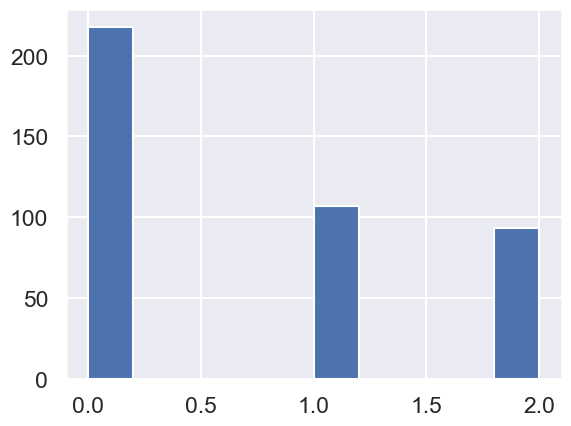

In [ ]:
#Plot data
plt.hist(X_test['Pclass'])
sensitive_feature_values = sorted(list(set(X['Pclass'])))

In [ ]:
y_test

321    0
324    0
388    0
56     0
153    0
      ..
71     0
106    0
270    0
348    0
102    0
Name: Survived, Length: 418, dtype: int64

In [ ]:
np.count_nonzero(y_test)

0

(array([  0.,   0.,   0.,   0.,   0., 418.,   0.,   0.,   0.,   0.]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5]),
 <BarContainer object of 10 artists>)

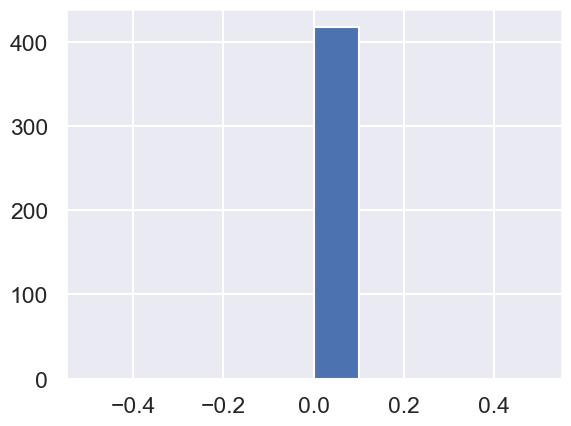

In [ ]:
plt.hist(list(y_test))

In [ ]:
C_list = [2**v for v in range(16,20)]    
#Oblivious SVM
print('OBLIVIOUS SVM')
obl = ObliviousData()
K = obl.build_K_lin(np.array(X),np.array(X))
O = obl.build_O_discrete(K,S)
Kt = obl.build_K_lin(np.array(X_test),np.array(X))
Ot = obl.build_Ot_discrete(Kt,np.array(S_test))

stdacc_list,true_acc_list,betas =[],[],[]
    
for c in C_list:
    print('C: ', c)
    clf = svm.SVC(kernel='precomputed', C=c)
    print('Fitting OBLIVIOUS SVM')
    clf.fit(O,y_train)
    pred_oblv = clf.predict(Ot)
    standard_missclassification_error=np.mean((pred_oblv==y_test)*1) # error with respect to observed labels 
    print('Standard Missclassification acc: ', standard_missclassification_error)
    # Dependence measure
    beta = estimate_beta_dependence(pred_oblv,X_test['Pclass'],unique_labels)
    print('Beta-Dependence: ',beta)
    stdacc_list.append(standard_missclassification_error)
    betas.append(beta)

OBLIVIOUS SVM
C:  0.0625
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.36363636363636365
Beta-Dependence:  0.039582427142235754
C:  0.125
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.361244019138756
Beta-Dependence:  0.049506650488770815
C:  0.25
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.361244019138756
Beta-Dependence:  0.049506650488770815
C:  0.5
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.361244019138756
Beta-Dependence:  0.049506650488770815
C:  1
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.3588516746411483
Beta-Dependence:  0.045946750303335504
C:  2
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.34688995215311
Beta-Dependence:  0.03293193837137426
C:  4
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.39952153110047844
Beta-Dependence:  0.08538037132849519
C:  8
Fitting OBLIVIOUS SVM
Standard Missclassification acc:  0.4354066985645933
Beta-Dependence:  0.19859893317460675
C:  16
Fitting OBL

In [ ]:
stdind=np.where(stdacc_list==np.max(stdacc_list))[0][0]
print('(standard error, dependence):')
print((stdacc_list[stdind], betas[stdind]))        


(standard error, dependence):
(0.45454545454545453, 0.2140060896041757)
